<a href="https://colab.research.google.com/github/annafumagalli/LISA-M-project/blob/master/CDAE_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab routines

In [1]:
!pip3 install torch

In [2]:
!git clone https://github.com/annafumagalli/LISA-M-project.git

Cloning into 'LISA-M-project'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 245 (delta 6), reused 0 (delta 0), pack-reused 226
Receiving objects: 100% (245/245), 9.73 MiB | 25.62 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [3]:
cd ./LISA-M-project

/content/LISA-M-project


---------------------------------

In [0]:
import sys
sys.path.insert(0, '/home/annaf/LDC_project/masters_project/lib/python3.6/site-packages')

In [0]:
%matplotlib inline
import numpy as np
import scipy
from scipy.stats.stats import pearsonr
from scipy.signal import chirp
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

import torch
from torch import nn, optim
from torch.autograd import Variable
from torchsummary import summary

from CDAE_model import *
from CDAE_training import *
#import MBH_phenomD as mbhb_ph

import copy
import random
import cv2

In [6]:
torch.cuda.get_device_name(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Testing the trained models

In [0]:
# Fixed dataset parameters

n = 1000      # number of training sets per batch
T = 60*10     # 10 min of data, sampled every 0.1 s
fs = 10       # sampling frequency
N = T*fs
t = np.linspace(0,T,N)

# FFT parameters

NFFT = 20*fs   # FTT time interval
NOVL = NFFT*0.71      # overlap
window = np.blackman(NFFT) 

In [0]:
def normalise(x):
    y = (x - x.min())/(x.max() - x.min())
    return y

In [9]:
# Load trained nets

#s_net = torch.load('./saved_models/s_net_14-02-2019_17:55:15.pt')
#sg_net = torch.load('./saved_models/sg_net_12-02-2019_17:30:49.pt')
#chirp_net = torch.load('./saved_models/chirp_net_14-02-2019_18:58:00.pt')
#ms_net = torch.load('./saved_models/ms_net_14-02-2019_19:55:00.pt')
#tchirp_net = torch.load('./saved_models/tchirp_net_14-02-2019_19:26:29.pt')

s_net = torch.load('./s_net_14-02-2019_17:55:15.pt')
#sg_net = torch.load('./saved_models/sg_net_12-02-2019_17:30:49.pt')
chirp_net = torch.load('./chirp_net_14-02-2019_18:58:00.pt')
ms_net = torch.load('./ms_net_14-02-2019_19:55:00.pt')
tchirp_net = torch.load('./tchirp_net_14-02-2019_19:26:29.pt')


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Tanh' has changed. you can retrieve the original source code by accessing the object's source attribute or set 

# 3 sines + 1 chirp

In [10]:
# Signals - the sine waves have different amplitude

ts_sine1 = 2.0*np.sin(2*np.pi*1.0*t)
ts_sine2 = 3.5*np.sin(2*np.pi*2.0*t)
ts_sine3 = 2.5*np.sin(2*np.pi*3.0*t)

k1 = (2.0/0.5)**(1/350.0)
ts_chirp1 = 5.0*np.sin(2.0*np.pi*0.5*((k1**t-1)/np.log(k1)))
#k2 = (2.5/1.5)**(1/350.0)
#ts_chirp2 = 1.0*np.sin(2.0*np.pi*0.5*((k2**t-1)/np.log(k2)))

# Time series

ts_mix1 = ts_sine1+ts_sine2+ts_sine3+ts_chirp1#+ts_chirp2

# Spectrograms

spec_sines,_,_ = plt.mlab.specgram((ts_sine1+ts_sine2+ts_sine3), NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
spec_chirp,_,_ = plt.mlab.specgram(ts_chirp1, NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
spec_mix1,_,_ = plt.mlab.specgram(ts_mix1, NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)

# Format for net input and comparisons (100x100)

spec_mix1 = normalise(spec_mix1)
spec_mix1 = spec_mix1[:100,:100]

spec_sines = normalise(spec_sines)
spec_sines = spec_sines[:100,:100]

spec_chirp = normalise(spec_chirp)
spec_chirp = spec_chirp[:100,:100]

spec_size=(spec_mix1.shape[0], spec_mix1.shape[1])

print(spec_size)

spec_mix1 = Variable(torch.from_numpy(spec_mix1)).to(device)
spec_mix1 = spec_mix1.reshape(1,1,spec_size[0],spec_size[1])
spec_mix1 = spec_mix1.type(torch.cuda.FloatTensor)

(100, 100)


In [0]:
# Apply trained models

chirp_test_out = chirp_net(spec_mix1)
s_test_out = s_net(spec_mix1)
#sg_test_out = sg_net(spec_mix1)

chirp_test_out = chirp_test_out.reshape(spec_size[0],spec_size[1]).detach().cpu().numpy()
s_test_out = s_test_out.reshape(spec_size[0],spec_size[1]).detach().cpu().numpy()

In [0]:
# Calculate overalp scores --- i.e. correlation coeffiecients

chirp_score,_ = scipy.stats.pearsonr(chirp_test_out.flat, spec_chirp.flat)
s_score,_ = scipy.stats.pearsonr(s_test_out.flat, spec_sines.flat)

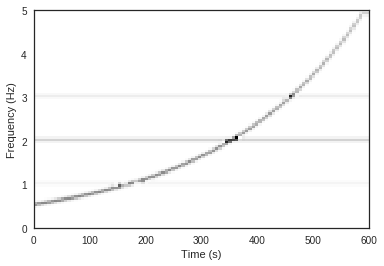

In [13]:
# Plot results

#%matplotlib notebook
#%matplotlib notebook  
#import matplotlib.pyplot as plt

plt.imshow(spec_mix1.reshape(spec_size[0],spec_size[1]).cpu().numpy(),aspect='auto', origin='lower', extent=[0,T,0,5])
#plt.title('Mixed input')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

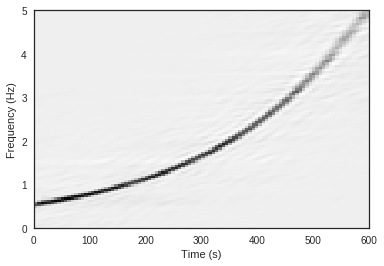

overlap score: 0.9406628180318023


In [14]:
plt.imshow(chirp_test_out,aspect='auto', origin='lower', extent=[0,T,0,5])
#plt.title('Cleaned chirp output')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

print('overlap score:',chirp_score)

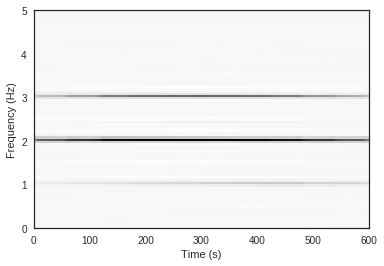

overlap score: 0.972115140274395


In [15]:
plt.imshow(s_test_out, aspect='auto', origin='lower', extent=[0,T,0,5])
#plt.title('Cleaned sine output')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

print('overlap score:', s_score)

## Truncated chirp + frequency modualted sine

In [0]:
# Signals

ts_ms1 = 1.5*np.sin(2*np.pi*1.5*t + + 55.0*np.sin(2*np.pi*20.0*t))
ts_ms2 = 1.5*np.sin(2*np.pi*3.5*t + + 150.0*np.sin(2*np.pi*20.0*t))

k1 = (2.5/0.5)**(1/250.0)
ts_tchirp1 = 2.5*np.sin(2.0*np.pi*0.2*((k1**t[:4600]-1)/np.log(k1)))
ts_tchirp1 = np.append(ts_tchirp1, np.zeros(1400))
#k2 = (2.5/1.3)**(1/250.0)
#ts_tchirp2 = 1.5*np.sin(2.0*np.pi*0.2*((k2**t-1)/np.log(k2)))
#ts_tchirp2 = np.append(ts_tchirp2, np.zeros(1400))

# Time series

ts_mix2 = ts_ms1+ts_ms2+ts_tchirp1#+ts_tchirp2

# Spectrograms

spec_ms,_,_ = plt.mlab.specgram((ts_ms1+ts_ms2), NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
spec_tchirp,_,_ = plt.mlab.specgram(ts_tchirp1, NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
spec_mix2,_,_ = plt.mlab.specgram(ts_mix2, NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)

# Format for net input (100x100)

spec_mix2 = normalise(spec_mix2)
spec_mix2 = spec_mix2[:100,:100]

spec_ms = normalise(spec_ms)
spec_ms = spec_ms[:100,:100]

spec_tchirp = normalise(spec_tchirp)
spec_tchirp = spec_tchirp[:100,:100]

spec_mix2 = Variable(torch.from_numpy(spec_mix2)).to(device)
spec_mix2 = spec_mix2.reshape(1,1,spec_size[0],spec_size[1])
spec_mix2 = spec_mix2.type(torch.cuda.FloatTensor)

In [0]:
# Apply trained models

tchirp_test_out = tchirp_net(spec_mix2)
ms_test_out = ms_net(spec_mix2)

tchirp_test_out = tchirp_test_out.reshape(spec_size[0],spec_size[1]).detach().cpu().numpy()
ms_test_out = ms_test_out.reshape(spec_size[0],spec_size[1]).detach().cpu().numpy()

In [0]:
# Calculate overalp scores --- i.e. correlation coeffiecients

tchirp_score,_ = scipy.stats.pearsonr(tchirp_test_out.flat, spec_tchirp.flat)
ms_score,_ = scipy.stats.pearsonr(ms_test_out.flat, spec_ms.flat)

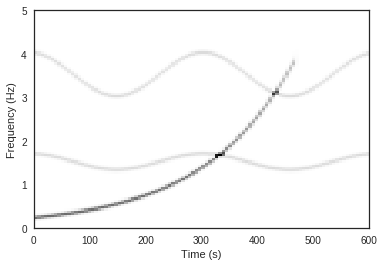

In [19]:
# Plot results

plt.imshow(spec_mix2.reshape(spec_size[0],spec_size[1]).cpu().numpy(),aspect='auto', origin='lower', extent=[0,T,0,5])
#plt.title('Mixed input')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

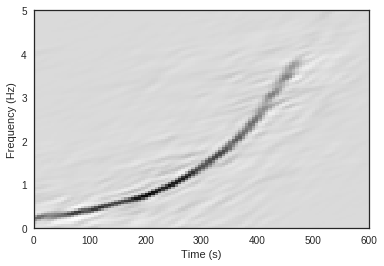

overlap score: 0.860623893573692


In [20]:
plt.imshow(tchirp_test_out,aspect='auto', origin='lower', extent=[0,T,0,5])
#plt.title('Cleaned chirp output')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

print('overlap score:', tchirp_score)

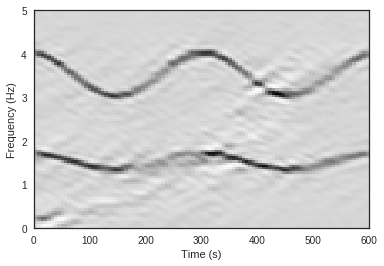

overlap score: 0.8086726750727109


In [21]:
plt.imshow(ms_test_out,aspect='auto', origin='lower', extent=[0,T,0,5])
#plt.title('Cleaned sine output')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

print('overlap score:', ms_score)

## Noisy mix

In [0]:
# Load trained nets

noisy_s_net = torch.load('./saved_models/noisy_s_net_05-02-2019_17:36:58.pt')
noisy_sg_net = torch.load('./saved_models/noisy_sg_net_05-02-2019_17:34:03.pt')
noisy_chirp_net = torch.load('./saved_models/noisy_chirp_net_05-02-2019_17:38:20.pt')


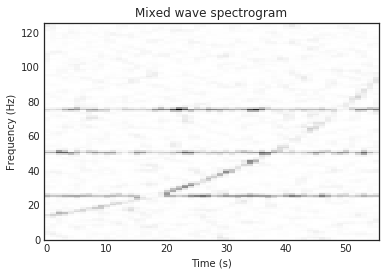

(126, 56)


In [0]:
ts_sine1 = 1.0*np.sin(2*np.pi*1.0*t)+np.random.normal(0.0, 0.7, N)
ts_sine2 = 1.0*np.sin(2*np.pi*2.0*t)+np.random.normal(0.0, 0.7, N)
ts_sine3 = 1.0*np.sin(2*np.pi*3.0*t)+np.random.normal(0.0, 0.7, N)
#ts_sg1 = 1.0*(np.exp(-(t-150.0)**2/10.0**2))*(np.cos(2*np.pi*4.5*(t-150.0)))
ts_chirp1 = chirp(t, 0.5, 200.0, 2.0, method='logarithmic')+np.random.normal(0.0, 0.7, N)
#ts_chirp2 = chirp(t, 1.0, t1, 1.5, method='logarithmic')

    
ts_mix = ts_sine1+ts_sine2+ts_sine3+ts_chirp1#+ts_sg1

noisy_spec_mix,_,_ = plt.mlab.specgram(ts_mix, NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)

noisy_spec_mix = normalise(noisy_spec_mix)

plt.imshow(noisy_spec_mix, aspect='auto', origin='lower')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Mixed wave spectrogram')

plt.show()

print(spec_mix.shape)

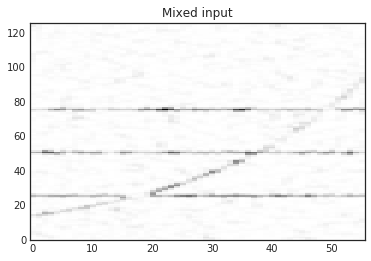

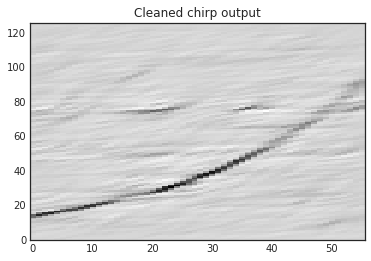

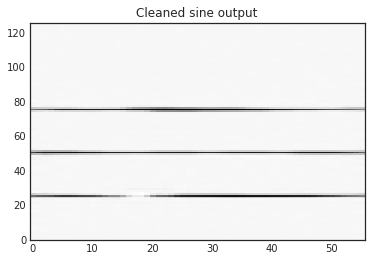

In [0]:
noisy_spec_mix = Variable(torch.from_numpy(noisy_spec_mix)).to(device)
noisy_spec_mix = noisy_spec_mix.reshape(1,1,spec_size[0],spec_size[1])
noisy_spec_mix = noisy_spec_mix.type(torch.cuda.FloatTensor)

chirp_test_out = chirp_net(noisy_spec_mix)
s_test_out = s_net(noisy_spec_mix)
sg_test_out = sg_net(noisy_spec_mix)

plt.imshow(noisy_spec_mix.reshape(spec_size[0],spec_size[1]).cpu().numpy(),aspect='auto', origin='lower')
plt.title('Mixed input')
plt.show()

plt.imshow(chirp_test_out.reshape(spec_size[0],spec_size[1]).detach().cpu().numpy(),aspect='auto', origin='lower')
plt.title('Cleaned chirp output')
plt.show()

plt.imshow(s_test_out.reshape(spec_size[0],spec_size[1]).detach().cpu().numpy(),aspect='auto', origin='lower')
plt.title('Cleaned sine output')
plt.show()